In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
# optimizer
ga = GA(
    dict(
        m = 75,
        x_rate = 0.5,
        m_rate = 0.6,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.5,
        grow_factor = 0.5,
        scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))
C:\Users\tcumi\github_repo\neural-network\python\ga.py:189: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.7716049382716049, Loss: 0.7477596424244068
Checkpoint 200, Accuracy: 0.7654320987654321, Loss: 0.7367105837221499
Checkpoint 300, Accuracy: 0.7716049382716049, Loss: 0.71592323868363
Checkpoint 400, Accuracy: 0.7901234567901234, Loss: 0.716612144752785
Checkpoint 500, Accuracy: 0.7839506172839507, Loss: 0.7130057017008463


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None:
        title = '{} VS {}'.format(x_label, y_label)
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

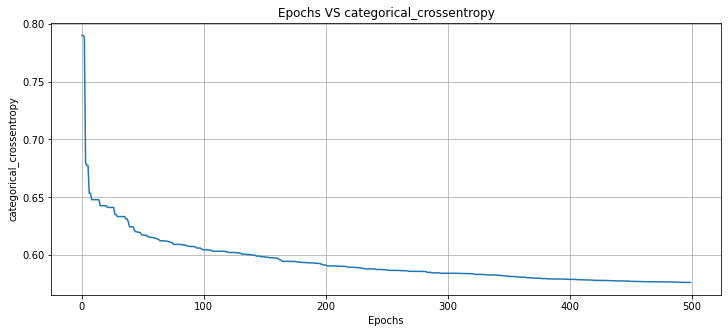

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.947115  ]
 [0.03053229]
 [0.02235271]]
[0. 1. 0.] <-> [[0.39945877]
 [0.39728782]
 [0.20325342]]
[0. 1. 0.] <-> [[0.3116231 ]
 [0.4433901 ]
 [0.24498677]]
[0. 0. 1.] <-> [[0.11560161]
 [0.35372838]
 [0.53067005]]
[0. 0. 1.] <-> [[0.0528442 ]
 [0.23459025]
 [0.71256554]]
[0. 1. 0.] <-> [[0.9298008]
 [0.0434382]
 [0.026761 ]]
[0. 0. 1.] <-> [[0.9580028 ]
 [0.01765077]
 [0.02434647]]
[1. 0. 0.] <-> [[0.9112268 ]
 [0.05661387]
 [0.03215937]]
[0. 0. 1.] <-> [[0.48935446]
 [0.34191072]
 [0.16873485]]
[1. 0. 0.] <-> [[0.90936744]
 [0.00948575]
 [0.08114686]]
[1. 0. 0.] <-> [[0.23525302]
 [0.4617795 ]
 [0.30296746]]
[0. 1. 0.] <-> [[0.16215855]
 [0.41844213]
 [0.4193993 ]]
[1. 0. 0.] <-> [[0.9453344 ]
 [0.03193158]
 [0.02273405]]
[1. 0. 0.] <-> [[0.4362271 ]
 [0.3752237 ]
 [0.18854922]]
[1. 0. 0.] <-> [[0.3546977 ]
 [0.42237937]
 [0.22292292]]
[0. 0. 1.] <-> [[0.94807154]
 [0.01296017]
 [0.03896828]]
[1. 0. 0.] <-> [[0.9534064 ]
 [0.01427853]
 [0.032315  ]]
[1. 0. 0.] <-> [[

In [12]:
# Testing Performance

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.7716049382716049, 'mean_square_error': 2.8800508250187766, 'categorical_crossentropy': 0.7477596424244068, 'precision': 0.6574074074074074, 'recall': 0.6574074074074074, 'f1': 0.6574074074074074, 'essential_metrics': {0: {'tp_hit': 59, 'fp_hit': 13, 'tn_hit': 19, 'fn_hit': 17}, 1: {'tp_hit': 2, 'fp_hit': 12, 'tn_hit': 79, 'fn_hit': 15}, 2: {'tp_hit': 10, 'fp_hit': 12, 'tn_hit': 81, 'fn_hit': 5}}, 'checkpoint': 100} 


{'accuracy': 0.7654320987654321, 'mean_square_error': 2.9012355335454463, 'categorical_crossentropy': 0.7367105837221499, 'precision': 0.6481481481481481, 'recall': 0.6481481481481481, 'f1': 0.6481481481481481, 'essential_metrics': {0: {'tp_hit': 59, 'fp_hit': 12, 'tn_hit': 20, 'fn_hit': 17}, 1: {'tp_hit': 4, 'fp_hit': 21, 'tn_hit': 70, 'fn_hit': 13}, 2: {'tp_hit': 7, 'fp_hit': 5, 'tn_hit': 88, 'fn_hit': 8}}, 'checkpoint': 200} 


{'accuracy': 0.7716049382716049, 'mean_square_error': 2.901775691228423, 'categorical_crossentropy': 0.71592323868363, 'precisio

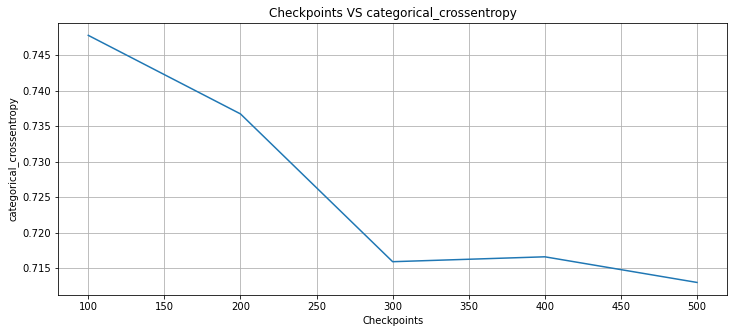

In [14]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

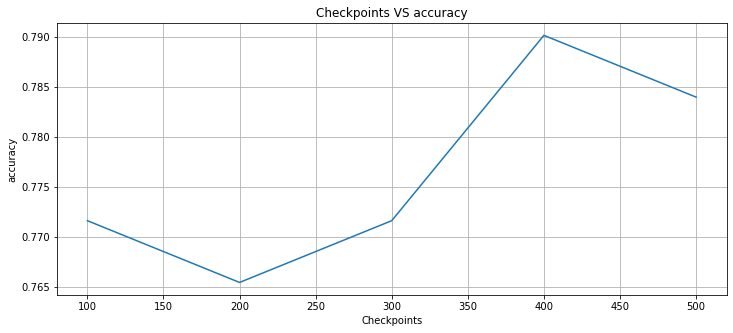

In [15]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [16]:
print(model)

Layer 1
Neuron 0: weights:
[[-0.16052021]
 [-1.385051  ]
 [-1.184581  ]
 [-1.5117928 ]
 [ 2.0942345 ]]
 bias: [-0.28666112]

Neuron 1: weights:
[[-0.7095386 ]
 [-0.55124825]
 [ 0.47192574]
 [ 1.5052849 ]
 [-2.0939553 ]]
 bias: [-3.]

Neuron 2: weights:
[[ 1.6659292]
 [ 1.9927685]
 [-2.0644736]
 [-2.5689282]
 [ 1.3573391]]
 bias: [-0.60963136]

Neuron 3: weights:
[[ 2.6879482 ]
 [-0.97300035]
 [ 0.8102618 ]
 [-1.6867002 ]
 [-0.7389069 ]]
 bias: [-3.]

$
Layer 2
Neuron 0: weights:
[[ 2.2805154]
 [-2.1503425]
 [-2.4867635]
 [-2.224858 ]]
 bias: [-0.00664036]

Neuron 1: weights:
[[-2.0611768]
 [-3.       ]
 [-1.2670588]
 [ 2.418327 ]]
 bias: [-0.08227296]

Neuron 2: weights:
[[-1.9755697]
 [ 3.       ]
 [ 2.9847581]
 [-2.259763 ]]
 bias: [-2.4003868]

$

